# Restoring a Saved Model#


<a id='introduction'></a>
## Introduction##
This is an example of loading an already trained model from disk and using it to make predictions.

<b>Table of Contents</b>
1. [Introduction](#introduction)
2. [Import Necessary Packages](#imports)
3. [Load and Normalize the Data](#load_data)
4. [Load the Model from and hdf5 Disk File](#load_model)
5. [Summarize the Training Results](#summarize)
6. [Conclusion](#conclusion)

<a id='imports'></a>
## Import Necessary Packages ##

First, let's run the cell below (put your cursor in the cell and press Shift-Enter) to import all the packages that you will need.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [keras](https://pypi.org/project/Keras/) is a high level neural network library for deep learning applications.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python. 
- [pandas](https://pandas.pydata.org/) is a data analysis library.
- [seaborn](https://seaborn.pydata.org/) is a data visualization library based on matplotlib.
- [scikitplot](https://anaconda.org/conda-forge/scikit-plot) is yet another plotting library.
- [sklearn](https://scikit-learn.org/stable/) is a collection of algorithms for classification, regression, and clustering.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.

In [1]:
# Import packages
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns       # for sns.heatmap
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
import tensorflow.python.util.deprecation as deprecation
from cb3_ann_utils import load_and_normalize_loan_data, describe_datasets, build_compile_fit_model, \
    my_f1_score, cb3_plot_confusion_matrix, cb3_calculateResults1, cb3_calculateResults2, cb3_displayResults

sns.set(style='white', context='notebook', palette='deep')
deprecation._PRINT_DEPRECATION_WARNINGS = False
%matplotlib inline

print("Done importing required modules.")

Using TensorFlow backend.
C:\Users\cbarlow\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cbarlow\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cbarlow\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:

Done importing required modules.


<a id='load_data'></a>
## Load and Normalize the Data ##

Use pandas.read_csv() function to read the loan data from a CSV disk files into a Pandas DataFrame, and then shuffle and split up the data into a training set, a dev set (also known as a "cross validation" or a "holdout" set), and a test set.  Training is only done on the training set.  The dev set it used to evaluate the ability of the trained network to generalize well and can be used to help "tune" hyperparameter settings.  Finally, the test set is used to see if the performance is relatively consistent between the dev set and the test set, so that we can have confidence that the test set performance is an accurate representation of how well the network will perform on data that was not seen during training (assuming the training data was a good representative sample).  NOTE: THE FIELDS IN THE DATA FILE MUST MATCH 100% THE FIELDS THAT WERE USED AS FEATURES WHILE TRAINING THE MODEL THAT WE WILL USE!  Also, when running future predictions on unlabeled data, you will need to know the original mean and standard deviation that were used to normalize the training data so they can also be applied to new data.  So in a production product, save the mean and standard deviation of the training data along with the model itself.

In [2]:
np.random.seed(31)    # in case you need to be able to duplicate exact shuffling of data

# Read CSV data
loan_data = pd.read_csv('datasets/AnonymousLoans20190930OregonStateFull.csv', index_col = 'LOAN_SERIAL')

# Extract and encode categorical features
ln_type_cat = loan_data[['LN_TYPE_CATEGORY']].astype(CategoricalDtype(["CC", "CE", "LC", "OE"]))
ln_type_cat = pd.get_dummies(ln_type_cat, prefix='LN_TYPE_CAT', drop_first=True)
ln_type_cat.head()

categorical_features = ln_type_cat

# Extract numerical features
#numerical_features = loan_data[['CREDIT_LIMIT', 'COBORROWER_COUNT', 'ORIGINAL_TERM_IN_MONTHS', 'BALANCE', 'MONTHLY_PMT', 'INTEREST_RATE', \
#                               'DQ_DAYS', 'STILL_MISSED_FIRST_PMT', 'HAS_COLLATERAL', 'AGE_IN_DAYS', 'MEMBERSHIP_DAYS', 'PMT_COUNT_MADE', \
#                               'PMT_COUNT_DQ_30_TO_59', 'PMT_COUNT_DQ_60_TO_89', 'PMT_COUNT_DQ_90_TO_119', \
#                               'PMT_COUNT_DQ_120_AND_UP', 'MONTHLY_INCOME', 'MONTHLY_EXPENSE', 'LR_AMOUNT', 'SCORE', 'AGE_OF_SCORE', \
#                               'AGGR_SHARE_COUNT', 'AGGR_SHARE_BAL', 'DD_CHANGE', 'CREDIT_LIMIT_INCREASE_COUNT', 'OFF_AUTO_PAY_COUNT']]
numerical_features = loan_data[['DQ_DAYS', 'AGGR_SHARE_BAL', 'PMT_COUNT_MADE', 'MONTHLY_PMT', 'PMT_COUNT_DQ_30_TO_59', \
                                'CREDIT_LIMIT', 'INTEREST_RATE', 'PMT_COUNT_DQ_90_TO_119', 'SCORE', \
                                'COBORROWER_COUNT', 'MONTHLY_EXPENSE']]
#loan_features = pd.concat([categorical_features, numerical_features], axis=1)
loan_features = numerical_features


loan_labels = loan_data['BINARY_STATUS']
frame = { 'BINARY_STATUS': loan_labels } 
loan_labels_df = pd.DataFrame(frame)

# Split the data up in train and dev sets
X_train, X_test, y_train, y_test = train_test_split(loan_features, loan_labels_df, train_size=0.8)
# Further split dev data into dev and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.50)

# Normalize the data
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)
train_std = np.where(train_std==0.0, 1.e-8, train_std) # avoid divide by zero error
X_train -= train_mean
X_train /= train_std
# scale dev data and test data based on train data mean and standard deviation!
X_dev -= train_mean
X_dev /= train_std
X_test -= train_mean
X_test /= train_std
    
n = X_train.shape[1]  # feature count
#describe_datasets(X_train, y_train, X_dev, y_dev, X_test, y_test, n)
describe_datasets(X_train, y_train, X_dev, y_dev, X_test, y_test, n)


11 features
Total size of dataset:  75271 loans ( 74786  good;  485  bad)
Size of Original Training Set:  60216 loans ( 59829  good;  387  bad)
Size of Dev Set:  7527 loans ( 7484  good;  43  bad)
Size of Test Set:  7528 loans ( 7473  good;  55  bad)



<a id='load_model'></a>
## Load the Model from an hdf5 Disk File ##
The model has already been trained previously, so now you can just load the model from an hdf5 disk file, and then run the summary() function to display the neural network architecture used.

In [3]:
# load model
model = load_model('./models/model_20200831_s31a.h5')
# summarize model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 11)                132       
_________________________________________________________________
batch_normalization_88 (Batc (None, 11)                44        
_________________________________________________________________
dense_118 (Dense)            (None, 11)                132       
_________________________________________________________________
batch_normalization_89 (Batc (None, 11)                44        
_________________________________________________________________
dense_119 (Dense)            (None, 11)                132       
_________________________________________________________________
batch_normalization_90 (Batc (None, 11)                44        
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 12        
Total para

<a id='summarize'></a>
## Summarize the Training Results ##
Display summary of various statistics about the performance of the model against the test data.


Results for Test Set:
Accuracy:  0.9938894792773645
Precision:  0.576271186440678
Recall:  0.6181818181818182
F1 Score:  0.5964912280701754


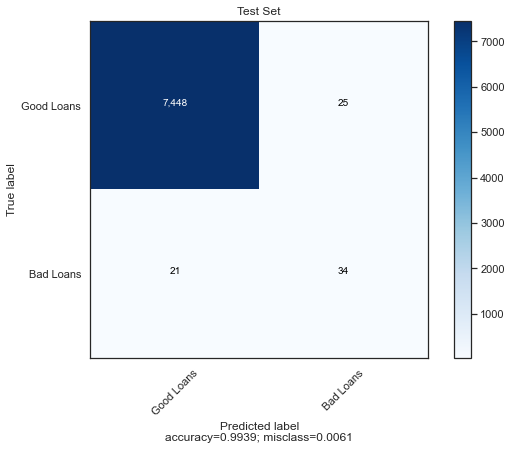

In [4]:
# Now make predictions on test data
y_pred_test = model.predict(X_test)
y_pred_test[y_pred_test>=0.5] = 1
y_pred_test[y_pred_test<0.5] = 0
y_test_numpy = y_test.to_numpy()

(tp, tn, fp, fn) = cb3_calculateResults1(y_pred_test, y_test_numpy)
(accuracy, precision, recall, f1, cm) = cb3_calculateResults2(tp, tn, fp, fn)
cb3_displayResults(accuracy, precision, recall, f1, cm, "Test Set")

Here are what the results would look like if we just set p(badLoan)=0:


Results for p(BadLoans)=0:
Accuracy:  0.9926939426142402
Precision:  None
Recall:  0.0
F1 Score:  0.0


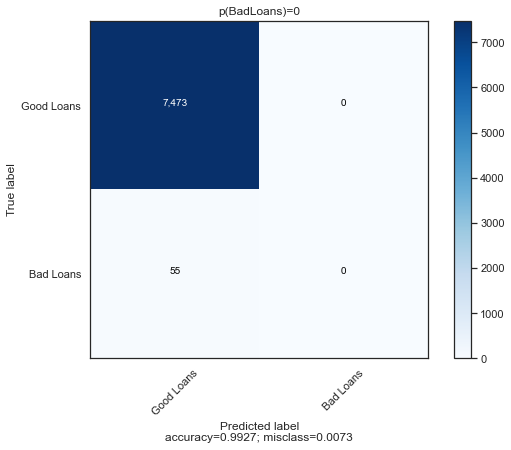

In [5]:
bad = tp + fn
good = tn + fp
totLoans = bad + good
(accuracy, precision, recall, f1, cm) = cb3_calculateResults2(0, good, 0, bad)
cb3_displayResults(accuracy, precision, recall, f1, cm, "p(BadLoans)=0")

And here are what the results would look like if we just randomly labeled a small number as bad (p(badLoan) = actual percentage bad) in hopes of improving accuracy from the p(badLoan) = 0 model:


Results for p(BadLoans)=observedProbability:
Accuracy:  0.9853878852284803
Precision:  0.0
Recall:  0.0
F1 Score:  0.0


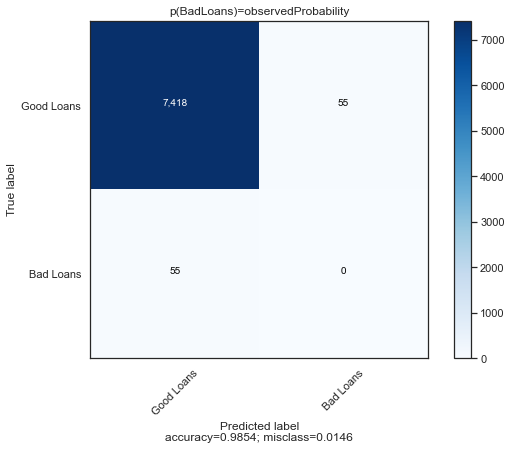

In [6]:
p = bad
n = good
tp = int(round(p * bad / totLoans))
fp = p - tp
tn = int(round(n * good / totLoans))
fn = n - tn
(accuracy, precision, recall, f1, cm) = cb3_calculateResults2(tp, tn, fp, fn)
cb3_displayResults(accuracy, precision, recall, f1, cm, "p(BadLoans)=observedProbability")

You can also look at roughly which input features had the most-to-least influence on predictions (take this simplistic interpretation of the weights in the first hidden layer with a grain of salt):

In [7]:
weights = np.sum(np.absolute(model.layers[0].get_weights()[0]), axis=1)
print("Weights in original feature order:")
print(weights)
wi = np.argsort(weights)
ws = sorted(weights)
print("\nWeights sorted most to least influential:")
for i in range(len(wi)-1, -1, -1):
    print(ws[i],X_train.columns.values[wi[i]])

Weights in original feature order:
[39.18607   44.472126  19.242756  20.983543  12.631996  14.526423
 12.618159   7.177519  13.9485855 13.44706   28.774515 ]

Weights sorted most to least influential:
44.472126 AGGR_SHARE_BAL
39.18607 DQ_DAYS
28.774515 MONTHLY_EXPENSE
20.983543 MONTHLY_PMT
19.242756 PMT_COUNT_MADE
14.526423 CREDIT_LIMIT
13.9485855 SCORE
13.44706 COBORROWER_COUNT
12.631996 PMT_COUNT_DQ_30_TO_59
12.618159 INTEREST_RATE
7.177519 PMT_COUNT_DQ_90_TO_119


We can also go back and look at a few examples of false negatives (where we predicted a good loan in the dev data, but it was actually bad), getting the full, non-normalized data from original_data. Then we can go back to the credit union and find these loans and examine them for further "inspiration" on what additional features might have made this more predictable. 

In [8]:
# Now look at up to three examples of false negatives for inspiration
false_negative_tuple = np.where(((y_pred_test==0) & (y_test_numpy==1)))
false_negative_array = false_negative_tuple[0]
l = len(false_negative_array)
if l>0:
    print("\nExamples of false negatives in test data:")
for i in range(min(l, 3)):
    loan_serial = X_test.index.values[false_negative_array[i]]
    print("\nLoan Serial ",loan_serial)
    print(loan_data.loc[loan_serial])


Examples of false negatives in test data:

Loan Serial  141795
LN_TYPE_CATEGORY                       CE
CREDIT_LIMIT                      20526.1
COBORROWER_COUNT                        0
ORIGINAL_TERM_IN_MONTHS                73
BALANCE                           19402.8
MONTHLY_PMT                        331.15
INTEREST_RATE                        4.99
DQ_DAYS                                46
STILL_MISSED_FIRST_PMT                  0
HAS_COLLATERAL                          1
AGE_IN_DAYS                         32209
MEMBERSHIP_DAYS                       237
PMT_COUNT_MADE                          5
PMT_COUNT_DQ_UNDER_30                   0
PMT_COUNT_DQ_30_TO_59                   0
PMT_COUNT_DQ_60_TO_89                   0
PMT_COUNT_DQ_90_TO_119                  0
PMT_COUNT_DQ_120_AND_UP                 0
MONTHLY_INCOME                          0
MONTHLY_EXPENSE                       695
LR_AMOUNT                               0
SCORE                                 677
AGE_OF_SCORE

Or we can list the serial numbers of <i>all</i> false negatives:

In [9]:
if l>0:
    print("\nFalse negatives in test data:")
for i in range(l):
    loan_serial = X_test.index.values[false_negative_array[i]]
    print("Loan Serial ",loan_serial)
    #print(loan_data.loc[loan_serial])


False negatives in test data:
Loan Serial  141795
Loan Serial  145908
Loan Serial  145443
Loan Serial  147167
Loan Serial  136919
Loan Serial  153393
Loan Serial  104183
Loan Serial  94900
Loan Serial  12306
Loan Serial  141562
Loan Serial  92231
Loan Serial  79383
Loan Serial  114305
Loan Serial  49443
Loan Serial  135058
Loan Serial  84621
Loan Serial  88931
Loan Serial  107266
Loan Serial  149534
Loan Serial  87699
Loan Serial  72024


<a id='conclusion'></a>
## Conclusion  ##
It takes much less time to make predictions using an existing, trained model, than it does to train a model in the first place.


[Return to top of Notebook](#introduction)